In [2]:
from fenics import *
from pyfftw import *
from numpy.random import default_rng
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import logging
import sys
sys.path.insert(0, '/home/s2079009/MAC-MIGS/PhD/PhD_code/CES')
from utils import circ_embedding
from utils import cov_functions
from utils import PDE_solver
from utils import periodisation_smooth
from MLMCwCE import MLMCwCircEmbedding

# suppress information messages (printing takes more time)
set_log_active(False)
logging.getLogger('FFC').setLevel(logging.WARNING)

# generator for random variables
rng = default_rng()

In [2]:
# the value at which to compute E[p(x,y)]
x_val = 7 / 15
y_val = 7 / 15
# choose RHS constant for the ODE
a_val = 1
# polynomial degree for computing FEM approximations
pol_degree_val = 1
# variance of random field
sigma = 1
# correlation length of random field
rho = 0.1
# smoothness parameter of random field
nu = 1.5
# mesh size for coarsest level
m_0_val = 16
# initial padding in circulant embedding matrix
J1_val = J2_val = 0
# norm to be used in covariance function of random field
p_val = 1

In [2]:
# determine m0 - nu = 1.5 and rho = 0.1
Q_hat_var_vec = np.array([0.021449437037861587, 0.011536404658801219, 0.00901149107295372, 0.009562518616819957, 0.008846204693822801, 0.01335252693250148, 0.009647906373429386, 0.006349407918547342])
Y_hat_var_vec_comp = np.array([0.017390938022723335, 0.005034107647615825, 0.0007808481940154523, 0.00012859002133400727, 2.187226315146163e-05, 5.014358680079132e-06, 1.7170801279290798e-06])

In [5]:
# determine m0 - nu = 1.5 and rho = 0.03
Q_hat_var_vec = np.array([0.010354626825823549, 0.00383292143338734250, 0.0016631369194711142, 0.0014730994161392934, 0.0014722725163897733, 0.0015092951065089795, 0.0016701129680670224]) # V[Q_l]
Y_hat_var_vec_comp = np.array([0.007945588866607997, 0.0038329214333873425, 0.0004482483112604702, 4.891968507708756e-05, 7.706351878373445e-06, 1.4153474281171596e-06]) # V[Y_l]
Q_hat_var_vec_smoothed = np.array([0.010171614014815498, 0.0032499319870131164, 0.0016787560556013289, 0.0013658452326838699, 0.001403555133465291, 0.001516912533268562, 0.0017011391044419982]) # V[\hat[Q]_l]
Y_hat_var_vec_comp_smoothed = np.array([0.0031285713352449092, 0.0005862274565281549, 0.00012969597156184843, 2.9428914294695343e-05, 7.055674306128563e-06, 1.0512684117288347e-06]) # V[\hat[Y]_l] with Q_l not smoothed and Q_{l-1} smoothed
Y_hat_var_vec_comp_smoothed_2 = np.array([0.0024636910189214235, 0.00047378672682046744, 0.00011572927117360418, 2.4504728839484555e-05, 6.093737576550448e-06, 1.2102834651092928e-06]) # V[\hat[Y]_l] with Q_l and Q_{l-1} smoothed

In [3]:
# determine m0 - nu = 1.5 and rho = 0.03
Q_hat_var_vec = np.array([0.002799839705823943, 0.0010106152189942998, 0.0004328502652953668, 0.00037597727210078244, 0.0003974412574268966, 0.00029456577478196726, 0.00035836979312696844]) # V[Q_l]
Y_hat_var_vec_comp = np.array([0.002316691350820578, 0.0006815798162798316, 9.52607179e-05, 8.58598649e-06, 9.04046417e-07, 1.44760281e-07]) # V[Y_l]
Q_hat_var_vec_smoothed = np.array([0.002183668434407944, 0.0009217566934658314, 0.0004410906233094394, 0.0003764751328144492, 0.0003981365882783795, 0.0002948001604086463, 0.000358383937015954]) # V[\hat[Q]_l]
Y_hat_var_vec_comp_smoothed = np.array([0.000897313618470343, 0.0003891334090288907, 8.781436100010833e-05, 4.062790612617989e-06, 7.217215251421391e-07, 1.8735537298029616e-07]) # V[\hat[Y]_l] with Q_l not smoothed and Q_{l-1} smoothed
Y_hat_var_vec_comp_smoothed_2 = np.array([0.0007700908653961595, 0.00037903695024118855, 8.782138500820956e-05, 4.065659106603089e-06, 7.23493307862371e-07, 1.8846308750485838e-07]) # V[\hat[Y]_l] with Q_l and Q_{l-1} smoothed

In [8]:
# determine m0 - nu = 0.5 and rho = 0.01
Q_hat_var_vec = np.array([0.02239724010051409, 0.010223898143254546, 0.0036781203025803614, 0.0011255701788778362, 0.00041007276954510514, 0.00021462978496169613, 0.00018081230172878123, 0.0002247967212478007])
Y_hat_var_vec_comp = np.array([0.018395298241443543, 0.0077317521258854546, 0.0029617069790771316, 0.0008741921545760162, 0.00020073227048453138, 3.4631268244509024e-05, 4.821333439698198e-06])

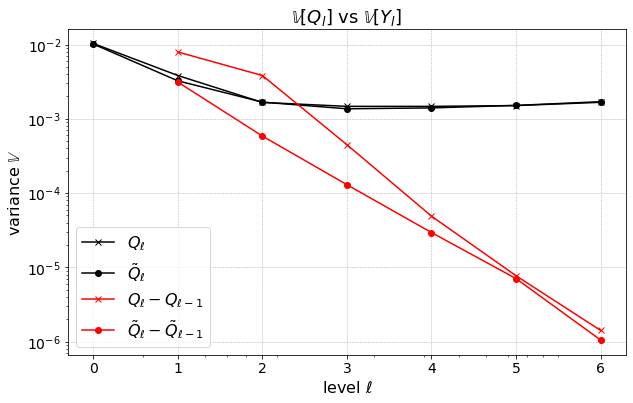

In [15]:
plt.figure(figsize=(10,6))
plt.loglog(2**np.array(np.arange(1,len(Q_hat_var_vec)+1)), Q_hat_var_vec, 'k-x', label=r'$Q_\ell$')
plt.loglog(2**np.array(np.arange(1,len(Q_hat_var_vec_smoothed)+1)), Q_hat_var_vec_smoothed, 'k-o', label=r'$\tilde{Q}_\ell$')
plt.loglog(2**np.array(np.arange(2,len(Y_hat_var_vec_comp)+2)), Y_hat_var_vec_comp, 'r-x', label=r'$Q_\ell - Q_{\ell-1}$')
plt.loglog(2**np.array(np.arange(2,len(Y_hat_var_vec_comp_smoothed_2)+2)), Y_hat_var_vec_comp_smoothed, 'r-o', label=r'$\tilde{Q}_\ell - \tilde{Q}_{\ell-1}$')
# plt.loglog(np.array(np.arange(2,len(Y_hat_var_vec_comp_smoothed_2)+2)), Y_hat_var_vec_comp_smoothed_2, 'g-*', label=r'$\mathbb{V}[Y_l]$')
plt.title(r'$\mathbb{V}[Q_l]$ vs $\mathbb{V}[Y_l]$', fontsize=18)
plt.xlabel(r'level $\ell$', fontsize=16)
plt.ylabel(r'variance $\mathbb{V}$', fontsize=16)
plt.grid(linestyle='--', linewidth=0.5)
plt.xticks(2**np.array([1,2,3,4,5,6,7]), [0,1,2,3,4,5,6], fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

In [27]:
Y_ls_vec = []
Y_hat_vec = []
Y_hat_var_vec = []
Y_ls_vec = []
Y_hat_vec = []
Y_hat_var_vec = []

In [368]:
# processing results
Y_ls = np.load('./data/Y_l_0_01_norm.npy', allow_pickle=True)

In [369]:
Y_ls_vec.append(Y_ls)

In [370]:
Y_hat_vec.append(np.abs(np.average(Y_ls)))
print(Y_hat_vec)

[0.63416285090155]


In [371]:
Y_hat_var_vec.append(1 / (len(Y_ls)-1) * np.sum((Y_ls - np.average(Y_ls)) ** 2))
print(Y_hat_var_vec)

[8.859174400985994e-05]


In [350]:
Y_ls_vec = np.array(Y_ls_vec)
Y_hat_vec = np.array(Y_hat_vec)
Y_hat_var_vec = np.array(Y_hat_var_vec)

In [335]:
M_vec = np.array([256, 1024, 4096, 16384, 65536])
alpha_val, C_alpha = np.polyfit(x=np.log(M_vec[1:]), y=np.log(Y_hat_vec[1:]), deg=1)
print(alpha_val)
print(C_alpha)

-0.3551417357831946
-3.631204069258538


In [22]:
M_vec = np.array([64, 256, 1024, 4096, 16384, 65536])
beta_val, C_beta = np.polyfit(x=np.log(M_vec[1:]), y=np.log(Y_hat_var_vec_comp_smoothed[1:]), deg=1)
print(beta_val)
print(C_beta)

-1.1223288607703445
-1.155299897423054


In [358]:
np.save('./data/Y_hat_var_vec_003_15.npy', Y_hat_var_vec, allow_pickle=True)

In [66]:
# alpha, beta - rho = 0.3 for point evaluation
M_vec = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
h_vec = 1/M_vec**(1/2)
Y_hat_vec = np.load('./data/Y_hat_vec_03.npy', allow_pickle=True)
alpha_val = 0.9984376672122427
C_alpha = -2.8857318719799454
Y_hat_var_vec = np.load('./data/Y_hat_var_vec_03.npy', allow_pickle=True)
beta_val = 1.92363651916377
C_beta = -1.3540083621279817
Y_ls_vec = np.load('./data/Y_ls_vec_03.npy', allow_pickle=True)

Y_hat_vec_NS_ld = np.load('../MLMCwLevDepCE/data/Y_hat_vec_NS_LD_03.npy', allow_pickle=True)
alpha_val_ld = 0.44236190432890393*2
C_alpha_ld = -3.3977088507672293
Y_hat_var_vec_NS_ld = np.load('../MLMCwLevDepCE//data/Y_hat_var_vec_NS_LD_03.npy', allow_pickle=True)
beta_val_ld = 0.9509908441481433*2
C_beta_ld = -1.4462067284096112

In [152]:
# alpha, beta - rho = 0.1 for point evaluation
M_vec = np.array([256, 1024, 4096, 16384, 65536])
h_vec = 1/M_vec**(1/2)
Y_hat_vec = np.load('./data/Y_hat_vec_01.npy', allow_pickle=True)
alpha_val = 0.4599735240350363*2
C_alpha = -2.6442549190384215
Y_hat_var_vec = np.load('./data/Y_hat_var_vec_01.npy', allow_pickle=True)
beta_val = 0.9662731979160691*2
C_beta = -0.7253450115361448
Y_ls_vec = np.load('./data/Y_ls_vec_01.npy', allow_pickle=True)

In [6]:
# alpha, beta - rho = 0.3 for L2 norm
M_vec = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
Y_hat_vec = np.load('./data/Y_hat_vec_03_norm.npy', allow_pickle=True)
alpha_val = 0.5222007194472896
C_alpha = -3.1188811144015007
Y_hat_var_vec = np.load('./data/Y_hat_var_vec_03_norm.npy', allow_pickle=True)
beta_val = 0.9684736717092111
C_beta = -2.500371724745198
Y_ls_vec = np.load('./data/Y_ls_vec_03_norm.npy', allow_pickle=True)

In [7]:
# alpha, beta - rho = 0.1 for L2 norm
M_vec = np.array([256, 1024, 4096, 16384, 65536])
Y_hat_vec = np.load('./data/Y_hat_vec_01_norm.npy', allow_pickle=True)
alpha_val = 0.48512019149955105
C_alpha = -2.9384007391256293
Y_hat_var_vec = np.load('./data/Y_hat_var_vec_01_norm.npy', allow_pickle=True)
beta_val = 0.9825882140583038
C_beta = -1.9871739238565482
Y_ls_vec = np.load('./data/Y_ls_vec_01_norm.npy', allow_pickle=True)

In [2]:
# alpha, beta - Matern rho = 0.1, nu=1.5 for point evaluation
M_vec = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
Y_hat_vec = np.load('./data/Y_hat_vec_01_15.npy', allow_pickle=True)
alpha_val = 0.4880265305585479
C_alpha = -3.0178444273516067
Y_hat_var_vec = np.load('./data/Y_hat_var_vec_01_15.npy', allow_pickle=True)
beta_val = 1.170525795936629
C_beta = -0.6782595941217687
Y_ls_vec = np.load('./data/Y_ls_vec_01_15.npy', allow_pickle=True)

In [181]:
# alpha, beta - Matern rho = 0.1, nu=1.5 for L2 norm
M_vec = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
h_vec = 1/M_vec**(1/2)
Y_hat_vec = np.load('./data/Y_hat_vec_01_15_norm.npy', allow_pickle=True)
alpha_val = 0.5732951241582027*2
C_alpha = -2.886461202278576
Y_hat_var_vec = np.load('./data/Y_hat_var_vec_01_15_norm.npy', allow_pickle=True)
beta_val = 1.2515893155836169*2
C_beta = -1.581159842476031
Y_ls_vec = np.load('./data/Y_ls_vec_01_15_norm.npy', allow_pickle=True)

Y_hat_vec_NS_ld = np.load('../MLMCwLevDepCE//data/Y_hat_vec_NS_LD_01_15_norm.npy', allow_pickle=True)
alpha_val_ld = 0.5609389916195612*2
C_alpha_ld = -2.9422970825490085
Y_hat_var_vec_NS_ld = np.load('../MLMCwLevDepCE//data/Y_hat_var_vec_NS_LD_01_15_norm.npy', allow_pickle=True)
beta_val_ld = 1.2175715201923831*2
C_beta_ld = -1.8646758531940137

In [192]:
# alpha, beta - Matern rho = 0.03, nu=1.5 for point evaluation
M_vec = np.array([256, 1024, 4096, 16384, 65536])
Y_hat_vec = np.load('./data/Y_hat_vec_003_15.npy', allow_pickle=True)
alpha_val = 0.3570868564486739
C_alpha = -3.053440188533286
Y_hat_var_vec = np.load('./data/Y_hat_var_vec_003_15.npy', allow_pickle=True)
beta_val = 1.3894538777401637
C_beta = 1.7933858349540437
Y_ls_vec = np.load('./data/Y_ls_vec_003_15.npy', allow_pickle=True)

In [196]:
# alpha, beta - Matern rho = 0.03, nu=1.5 for L2 norm
M_vec = np.array([256, 1024, 4096, 16384, 65536])
Y_hat_vec = np.load('./data/Y_hat_vec_003_15_norm.npy', allow_pickle=True)
alpha_val = 0.3551417357831946*2
C_alpha = -3.631204069258538
Y_hat_var_vec = np.load('./data/Y_hat_var_vec_003_15_norm.npy', allow_pickle=True)
beta_val = 1.5666865274225823*2
C_beta = 1.470065536870814
Y_ls_vec = np.load('./data/Y_ls_vec_003_15_norm.npy', allow_pickle=True)

M_vec = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
h_vec = 1/M_vec**(1/2)

Y_hat_vec_NS_ld = np.load('../MLMCwLevDepCE//data/Y_hat_vec_NS_LD_003_15_norm.npy', allow_pickle=True)
alpha_val_ld = 0.3203869583916329*2
C_alpha_ld = -4.125424298666542
Y_hat_var_vec_NS_ld = np.load('../MLMCwLevDepCE//data/Y_hat_var_vec_NS_LD_003_15_norm.npy', allow_pickle=True)
beta_val_ld = 1.325511867482945*2
C_beta_ld = -0.935727804503858

In [20]:
alpha_val, C_alpha = np.polyfit(x=np.log(h_vec[1:]), y=np.log(Y_hat_vec[1:]), deg=1)
print(alpha_val)
print(C_alpha)

0.9984376672122427
-2.8857318719799454


In [21]:
beta_val, C_beta = np.polyfit(x=np.log(h_vec[1:]), y=np.log(Y_hat_var_vec[1:]), deg=1)
print(beta_val)
print(C_beta)

1.92363651916377
-1.3540083621279817


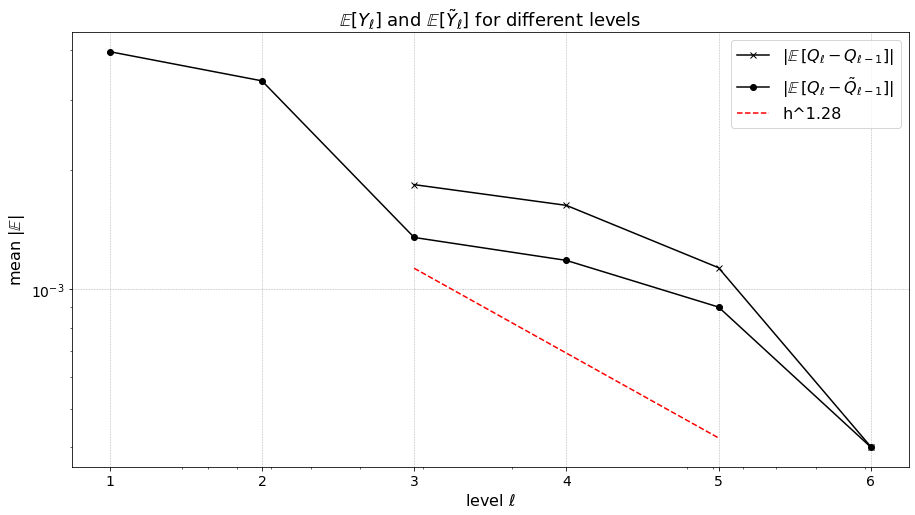

In [233]:
# plotting alpha
plt.figure(1, figsize=(15,8))
# use log-log scale
plt.loglog(h_vec[3:], Y_hat_vec[1:], 'k-x' , label=r'$|\mathbb{E} \, [Q_\ell - Q_{\ell-1}]|$')
plt.loglog(h_vec[1:], Y_hat_vec_NS_ld[1:], 'k-o' , label=r'$|\mathbb{E} \, [Q_\ell - \tilde{Q}_{\ell-1}]|$')
# find y values for best linear fit
y_fit_alpha = np.exp(alpha_val*np.log(h_vec[1:]) + C_alpha)
# plot best linear fit
plt.plot(h_vec[3:6], 0.5*y_fit_alpha[2:5], 'r--', label=f'h^{round(2*alpha_val_ld, 2)}')

# # find y values for best linear fit
# y_fit_alpha = np.exp(alpha_val_ld*np.log(h_vec[1:]) + C_alpha_ld)
# # plot best linear fit
# plt.plot(h_vec[3:6], 0.5*y_fit_alpha[2:5], 'r--', label=f'h^{round(alpha_val, 2)}')

plt.title(r'$\mathbb{E}[Y_\ell]$ and $\mathbb{E}[\tilde{Y}_\ell]$ for different levels', fontsize=18)
plt.xlabel(r'level $\ell$', fontsize=16)
plt.ylabel(r'mean $|\mathbb{E}|$', fontsize=16)
plt.grid(linestyle='--', linewidth=0.5)
plt.gca().invert_xaxis()
plt.xticks(h_vec[1:], np.arange(1, 7), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

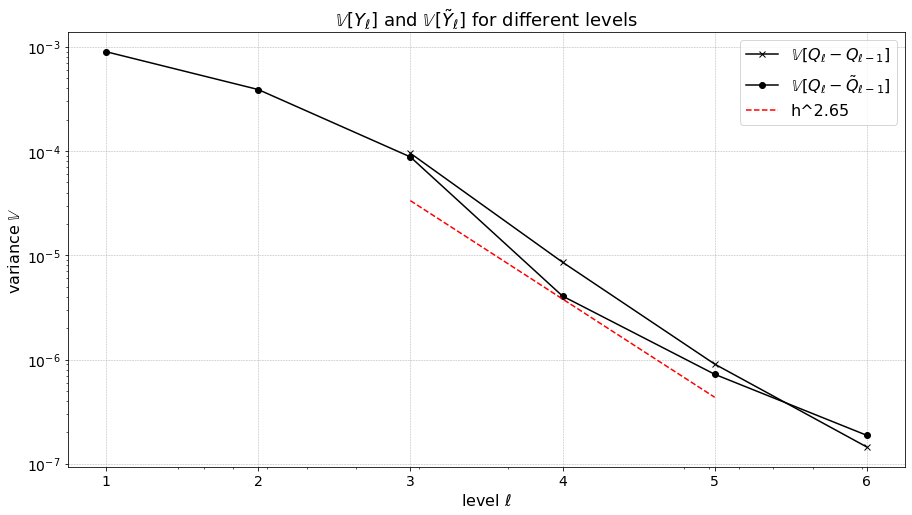

In [234]:
# plotting beta
plt.figure(2, figsize=(15,8)) 
# use log-log scale
plt.loglog(h_vec[3:], Y_hat_var_vec[1:], 'k-x' , label=r'$\mathbb{V} \, [Q_\ell - Q_{\ell-1}]$')
plt.loglog(h_vec[1:], Y_hat_var_vec_NS_ld[1:], 'k-o' , label=r'$\mathbb{V} \, [Q_\ell - \tilde{Q}_{\ell-1}]$')
# y values for best linear fit
y_fit_beta = np.exp(beta_val*np.log(h_vec[1:]) + C_beta)
# plot linear fit
plt.plot(h_vec[3:6], 0.4*y_fit_beta[2:5], 'r--', label=f'h^{round(beta_val_ld, 2)}')

plt.title(r'$\mathbb{V} \, [Y_\ell]$ and $\mathbb{V} \, [\tilde{Y}_\ell]$ for different levels', fontsize=18)
plt.xlabel(r'level $\ell$', fontsize=16)
plt.ylabel(r'variance $\mathbb{V}$', fontsize=16)
plt.grid(linestyle='--', linewidth=0.5)
plt.xticks(h_vec[1:], np.arange(1, 7), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.gca().invert_xaxis()
plt.show()

In [80]:
# gamma - rho = 0.3
M_vec = np.array([16, 64, 256, 1024, 4096, 16384, 65536])
h_vec = 1/M_vec**(1/2)
gamma_val = 0.9341306614068227*2
C_gamma = -7.410259655355176
avg_times_vec = np.load('./data/avg_times_vec_03.npy', allow_pickle=True)

In [197]:
# gamma - rho = 0.1
M_vec = np.array([256, 1024, 4096, 16384, 65536])
gamma_val = 1.0146062334408432
C_gamma = -8.089384773872528
avg_times_vec = np.load('./data/avg_times_vec_01.npy', allow_pickle=True)

In [375]:
# gamma - nu = 1.5 and rho = 0.03 - m0=16
M_vec = np.array([256, 1024, 4096, 16384, 65536])
avg_times_vec = np.load('../MLMCwLevDepCE/data/avg_times_vec_LD_15.npy')
avg_times_vec = avg_times_vec[3:]
gamma_val = 0.9868719259553745
C_gamma = -8.510608041617592

In [310]:
# gamma - nu = 0.5 and rho = 0.01 - m0=32
M_vec = np.array([1024, 4096, 16384, 65536])
avg_times_vec = np.load('../MLMCwLevDepCE/data/avg_times_vec_LD_15.npy')
avg_times_vec = avg_times_vec[4:]
gamma_val = 0.9655964998322105
C_gamma = -8.304150018762835

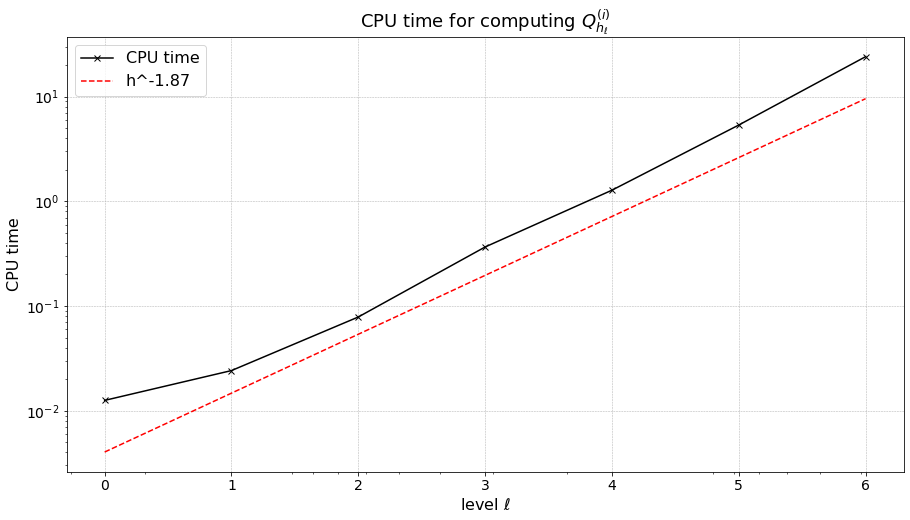

In [149]:
# plotting gamma
plt.figure(3, figsize=(15,8))
# use log-log scale
plt.loglog(h_vec, avg_times_vec, 'k-x' ,label='CPU time')

# the graph is more like a curve so we fit 2 lines - one through the first 4 
# points and last 3 points. The average should be close to gamma_val.

# line through first 4 points 
gamma, C_gamma = \
    np.polyfit(x=np.log(h_vec), y=np.log(avg_times_vec), deg=1)
y_fit_gamma = np.exp(gamma*np.log(h_vec) + C_gamma)
# gamma_2, C_gamma_2 = \
#     np.polyfit(x=np.log(h_vec[2:]), y=np.log(avg_times_vec[2:]), deg=1)
# y_fit_gamma_2 = np.exp(gamma_2*np.log(h_vec[2:]) + C_gamma_2)
plt.plot(h_vec, 0.5*y_fit_gamma, 'r--', label=f'h^{round(gamma, 2)}')
# plt.plot(M_vec[2:], 1.75*y_fit_gamma_2, 'c--', label=f'x^{round(gamma_2, 2)}')

plt.title(r'CPU time for computing $Q_{h_\ell}^{(i)}$', fontsize=18)
plt.xlabel(r'level $\ell$', fontsize=16)
plt.ylabel('CPU time', fontsize=16)
plt.grid(linestyle='--', linewidth=0.5)
plt.xticks(h_vec, np.arange(0, 7), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.gca().invert_xaxis()
plt.show()

In [ ]:
# running MLMC simulation without smoothing for different epsilons

# list of different accuracies
epsilons = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, \
    0.00075, 0.0005]

# total number of simulations
N_sim = len(epsilons)

# empty lists for saving the error and time needed
rmse_vec = np.zeros(N_sim)
time_vec = np.zeros(N_sim)
exp_vec = np.zeros(N_sim)
N_ls_vec = []

# for each accuracy
for i in range(N_sim):
    epsilon = epsilons[i]

    print(f'Starting simulation for epsilon = {epsilon}.')

    # MLMC simulation
    Y_ls_vec, Y_hat_vec, Y_hat_var_vec, rmse_val, total_time_val, exp_est_val, N_ls_val = MLMCwCircEmbedding.MLMC_simulation(Y_ls_vec, Y_hat_vec, Y_hat_var_vec, x_val, y_val, a_val, epsilon, alpha_val, gamma_val, C_gamma, avg_times_vec, J1_val, J2_val, cov_functions.expopnential_cov, m_0_val, pol_degree_val, sigma, rho, nu, p_val)

    print(f'Final estimate is {exp_est_val}.')
    print(f'Total time is {total_time_val}.')
    print(f'Final RMSE is {rmse_val} < {epsilon}.\n\n')

    # save current values
    rmse_vec[i]= rmse_val
    time_vec[i] = total_time_val
    exp_vec[i] = exp_est_val
    N_ls_vec.append(N_ls_val)

In [6]:
# parameters - rho = 0.3 for point evaluation
Y_hat_vec = np.load('./data/Y_hat_vec_03.npy', allow_pickle=True)
alpha_val = 0.49921883360612135
C_alpha = -2.8857318719799454
Y_hat_var_vec = np.load('./data/Y_hat_var_vec_03.npy', allow_pickle=True)
beta_val = 0.961818259581885
C_beta = -1.3540083621279817
avg_times_vec = np.load('./data/avg_times_vec_03.npy', allow_pickle=True)
gamma_val = 0.9341306614068227
C_gamma = -7.410259655355176
Y_ls_vec = np.load('./data/Y_ls_vec_03.npy', allow_pickle=True)

In [8]:
# paramters - rho = 0.1 for point evaluation
Y_hat_vec = np.load('./data/Y_hat_vec_01.npy', allow_pickle=True)
alpha_val = 0.4599735240350363
C_alpha = -2.6442549190384215
Y_hat_var_vec = np.load('./data/Y_hat_var_vec_01.npy', allow_pickle=True)
beta_val = 0.9662731979160691
C_beta = -0.7253450115361448
avg_times_vec = np.load('./data/avg_times_vec_01.npy', allow_pickle=True)
gamma_val = 1.0146062334408432
C_gamma = -8.089384773872528
Y_ls_vec = np.load('./data/Y_ls_vec_01.npy', allow_pickle=True)

In [10]:
# parameters - rho = 0.3 for L2 norm
Y_hat_vec = np.load('./data/Y_hat_vec_03_norm.npy', allow_pickle=True)
alpha_val = 0.5222007194472896
C_alpha = -3.1188811144015007
Y_hat_var_vec = np.load('./data/Y_hat_var_vec_03_norm.npy', allow_pickle=True)
beta_val = 0.9684736717092111
C_beta = -2.500371724745198
avg_times_vec = np.load('./data/avg_times_vec_03.npy', allow_pickle=True)
gamma_val = 0.9341306614068227
C_gamma = -7.410259655355176
Y_ls_vec = np.load('./data/Y_ls_vec_03_norm.npy', allow_pickle=True)

In [12]:
# parameters - rho = 0.1 for L2 norm
Y_hat_vec = np.load('./data/Y_hat_vec_01_norm.npy', allow_pickle=True)
alpha_val = 0.48512019149955105
C_alpha = -2.9384007391256293
Y_hat_var_vec = np.load('./data/Y_hat_var_vec_01_norm.npy', allow_pickle=True)
beta_val = 0.9825882140583038
C_beta = -1.9871739238565482
avg_times_vec = np.load('./data/avg_times_vec_01.npy', allow_pickle=True)
gamma_val = 1.0146062334408432
C_gamma = -8.089384773872528
Y_ls_vec = np.load('./data/Y_ls_vec_01_norm.npy', allow_pickle=True)

In [18]:
# parameters - Matern rho = 0.1, nu=1.5 for point evaluation
Y_hat_vec = np.load('./data/Y_hat_vec_01_15.npy', allow_pickle=True)
alpha_val = 0.4880265305585479
C_alpha = -3.0178444273516067
Y_hat_var_vec = np.load('./data/Y_hat_var_vec_01_15.npy', allow_pickle=True)
beta_val = 1.170525795936629
C_beta = -0.6782595941217687
gamma_val = 0.9341306614068227
C_gamma = -7.410259655355176
avg_times_vec = np.load('./data/avg_times_vec_03.npy', allow_pickle=True)
Y_ls_vec = np.load('./data/Y_ls_vec_01_15.npy', allow_pickle=True)

In [20]:
# parameters - Matern rho = 0.1, nu=1.5 for L2 norm
Y_hat_vec = np.load('./data/Y_hat_vec_01_15_norm.npy', allow_pickle=True)
alpha_val = 0.5732951241582027
C_alpha = -2.886461202278576
Y_hat_var_vec = np.load('./data/Y_hat_var_vec_01_15_norm.npy', allow_pickle=True)
beta_val = 1.2515893155836169
C_beta = -1.581159842476031
gamma_val = 0.9341306614068227
C_gamma = -7.410259655355176
avg_times_vec = np.load('./data/avg_times_vec_03.npy', allow_pickle=True)
Y_ls_vec = np.load('./data/Y_ls_vec_01_15_norm.npy', allow_pickle=True)

In [22]:
# parameters - Matern rho = 0.03, nu=1.5 for point evaluation
Y_hat_vec = np.load('./data/Y_hat_vec_003_15.npy', allow_pickle=True)
alpha_val = 0.3570868564486739
C_alpha = -3.053440188533286
Y_hat_var_vec = np.load('./data/Y_hat_var_vec_003_15.npy', allow_pickle=True)
beta_val = 1.3894538777401637
C_beta = 1.7933858349540437
avg_times_vec = np.load('../MLMCwLevDepCE/data/avg_times_vec_LD_15.npy')
avg_times_vec = avg_times_vec[3:]
gamma_val = 0.9868719259553745
C_gamma = -8.510608041617592
Y_ls_vec = np.load('./data/Y_ls_vec_003_15.npy', allow_pickle=True)

In [24]:
# parameters - Matern rho = 0.03, nu=1.5 for L2 norm
Y_hat_vec = np.load('./data/Y_hat_vec_003_15_norm.npy', allow_pickle=True)
alpha_val = 0.3551417357831946
C_alpha = -3.631204069258538
Y_hat_var_vec = np.load('./data/Y_hat_var_vec_003_15_norm.npy', allow_pickle=True)
beta_val = 1.5666865274225823
C_beta = 1.470065536870814
Y_ls_vec = np.load('./data/Y_ls_vec_003_15_norm.npy', allow_pickle=True)
avg_times_vec = np.load('../MLMCwLevDepCE/data/avg_times_vec_LD_15.npy')
avg_times_vec = avg_times_vec[3:]
gamma_val = 0.9868719259553745
C_gamma = -8.510608041617592

In [25]:
epsilon = 0.1 # accuracy

print(f'Starting simulation for epsilon = {epsilon}.')

 # MLMC simulation
Y_ls_vec, Y_hat_vec, Y_hat_var_vec, rmse_val, total_time_val, exp_est_val, N_ls_val = MLMCwCircEmbedding.MLMC_simulation(Y_ls_vec, Y_hat_vec, Y_hat_var_vec, x_val, y_val, a_val, epsilon, alpha_val, gamma_val, C_gamma, avg_times_vec, cov_functions.Matern_cov, periodisation_smooth.periodic_cov_fun, m_0_val, pol_degree_val, sigma, rho, nu, p_val)

print(f'Final estimate is {exp_est_val}.')
print(f'Total time is {total_time_val}.')
print(f'Final RMSE is {rmse_val} < {epsilon}.\n\n')

# save current values
print(f'rmse_val = {rmse_val}')
print(f'total_time_val = {total_time_val}')
print(f'exp_est_val = {exp_est_val}')
print(f'N_ls_val = {N_ls_val}')

Starting simulation for epsilon = 0.1.


Starting level 0.

Expectation estimate is 0.6332835416032083.
New number of samples is [1].

The sample variance is 0.000429920920902309 < 0.005000000000000001.


Starting level 1.

Expectation estimate is 0.635118713378675.
New number of samples is [1 1].

The sample variance is 0.0005251816388443865 < 0.005000000000000001.
Discretisation error is 8.322767161454125e-06 < 0.005000000000000001.
RMSE is 0.023097714302628313 < 0.1.

Stopped at level 1.

Final estimate is 0.635118713378675.
Total time is 0.00033402442932128906.
Final RMSE is 0.023097714302628313 < 0.1.


rmse_val = 0.023097714302628313
total_time_val = 0.00033402442932128906
exp_est_val = 0.635118713378675
N_ls_val = [1 1]


In [ ]:
0.63530744954 # rho = 0.3 point evaluation
0.6320961589136405 # rho = 0.1 point evaluation
0.6427883465505184 # rho = 0.3 L2 norm
0.639824704063681 # rho = 0.1 L2 norm
0.6275363445051334 # Matern rho = 0.1, nu=1.5 for point evaluation
0.6371412034403666 # Matern rho = 0.1, nu=1.5 for L2 norm
0.630611468922694 #  Matern rho = 0.03, nu=1.5 for point evaluation
0.635118713378675 # Matern rho = 0.03, nu=1.5 for L2 norm

In [411]:
# compute total time
N_ls_val = np.array([5141, 1096,  166,   28,    6])

print(N_ls_val[0]*avg_times_vec[0] + np.sum(np.array([N_ls_val[i]*(avg_times_vec[i]+avg_times_vec[i-1]) for i in range(1,np.size(N_ls_val))])))

844.8779828071595


In [6]:
# results - rho = 0.3 for point evaluation
rmse_vec = np.array([0.06657161475007298, 0.052378806652925144, 0.03517545469572756, 0.018175089578125195, 0.008393318570838526, 0.006220938320176527, 0.0045533838608949615, 0.0020471074424085987, 0.0009188571706938014, 0.0005533262021730351, 0.0004958024615114628])

time_vec = np.array([0.17390038967132568, 0.28595767736434935, 0.6337584567070007, 2.4982978177070616, 15.512412705421447, 27.569150819778443, 218.9177100610733, 1338.6571332240105, 11853.073735003472, 28592.944279751777, 47523.79832875967])

In [68]:
# results - rho = 0.1 for point evaluation
rmse_vec = np.array([0.05258168435760563, 0.04717389429274711, 0.03206495962897791, 0.01774740893325911, 0.007758863596842575, 0.006971887905938647, 0.00482017986115953, 0.0023736072396182708, 0.0008318586371570112, 0.0006808345759051815])

time_vec = np.array([0.7122645688056946, 0.79639976978302, 1.6769347405433654, 5.244026863574982, 32.22137799024582, 57.016983170509334, 127.71338842630385, 1001.566103951931, 16532.464946668148, 28361.378874747752])

In [ ]:
# results - rho = 0.3 for L2 norm
rmse_vec = np.array([0.05674256675403835, 0.04973621046530198, 0.032034450606141046, 0.0179421006151944, 0.008523172318271313, 0.007120768504153618, 0.004311401052814647, 0.002101236342506389, 0.0008339667468250896, 0.0006889687725964118, 0.0003702229083507306])

time_vec = np.array([0.07439664840698242, 0.09950374126434326, 0.23574349164962768, 0.795105299949646, 4.797588152885437, 8.55084933757782, 39.13525393009186, 269.67090037345884, 2537.077354123592, 4518.943066165447, 14262.560935726167])

In [256]:
# results rho = 0.1 for L2 norm
rmse_vec = np.array([0.044159729407085985, 0.03249279299271999, 0.02752601608517512, 0.016169303597888433, 0.007295547344151267, 0.005628307678240782, 0.0040132097954896605, 0.0020229753237367386, 0.0008513698349386931, 0.0007122501889708827, 0.000437610093267769])

time_vec = np.array([0.5439941668510436, 0.628129367828369, 0.7122645688056946, 1.7610699415206907, 8.726983785629272, 15.440492026805876, 34.82379994153976, 265.96393942832947, 2743.915654604435, 4864.701638970375, 16953.142398648262])

In [47]:
# results - rho = 0.1 and nu=1.5 for point evaluation
rmse_vec = np.array([0.0668482945540582, 0.04829263810488426, 0.035214641502676176, 0.01800459190826919, 0.00817696650257244, 0.006712153969335222, 0.004358949839243937, 0.0020431043260769064, 0.0008508857766726689, 0.0007102075184439114, 0.00038739540382815084])

time_vec = np.array([0.14879329681396483, 0.28503304719924927, 0.5458836317062378, 2.170980980396271, 13.399718384742737, 23.809168026447296, 145.63192592382433, 756.8816876029969, 5926.884764175415, 10679.76296164751, 31111.831528406146])

In [41]:
# results - rho = 0.1 and nu=1.5 for L2 norm
rmse_vec = np.array([0.055502444368434385, 0.05043079981117337, 0.03462978130081183, 0.017753055771014, 0.007625934301726962, 0.0060615996992987795, 0.004598496221297167, 0.0020986088785920876, 0.0009038766306868109, 0.0005519944688543053, 0.00038522127373735667])

time_vec = np.array([0.061843101978302, 0.07439664840698242, 0.16134684324264525, 0.6202802801132201, 3.832814338207245, 6.7603153491020205, 15.220124695301056, 153.0461678147316, 1228.4622011256217, 2666.7871075677867, 5958.2588822650905])

In [414]:
# results - rho = 0.03 and nu=1.5 for point evaluation
rmse_vec = np.array([0.04637985442252881, 0.03642671811483972, 0.032437284484663646, 0.018074859239469353, 0.009018866866443011, 0.006663345952532919, 0.004292614093084413, 0.0021771031213350103, 0.001472141957838984])

time_vec = np.array([0.28462793827056887, 0.32980272769927976, 0.3749775171279907, 1.260456919670105, 7.607916307449341, 24.668240427970886, 80.42555069923401, 417.35008945465086, 1958.7063294172287])

In [28]:
# results - rho = 0.03 and nu=1.5 for L2 norm
rmse_vec = np.array([0.053097714302628313, 0.023097714302628313, 0.015712748287223167, 0.007484814109425654, 0.005946971492396499, 0.004552878861663974, 0.0018168823316187658, 0.0009383627018201585, 0.0008219914185719052])
time_vec = np.array([0.18462793827056887, 0.28462793827056887, 0.3749775171279907, 1.7709588050842284, 3.121765303611755, 6.7992072820663445, 84.47114748954773, 485.88741490840914, 844.8779828071595])

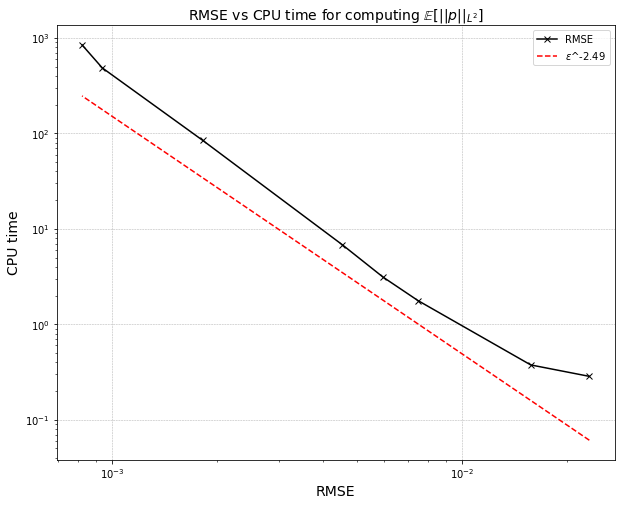

In [31]:
# plotting MLMC simulation results
plt.figure(4, figsize=(10,8))
# use log-log scale
plt.loglog(rmse_vec[1:], time_vec[1:], 'k-x', label = "RMSE")
# compute best linear fit only for last 5 values
slope, interc = \
    np.polyfit(x=np.log(rmse_vec[1:]), y=np.log(time_vec[1:]), deg=1)
# compute y values for best linear fit
y_fit = np.exp(slope*np.log(rmse_vec[1:]) + interc)
# plot best linear fit
plt.loglog(rmse_vec[1:], 0.4*y_fit, 'r--', label = rf'$\epsilon$^{round(slope,2)}')

plt.title(r'RMSE vs CPU time for computing $\mathbb{E}\left[||p||_{L^2}\right]$', fontsize=14)
plt.xlabel('RMSE', fontsize=14)
plt.ylabel('CPU time', fontsize=14)
plt.grid(linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.show()

In [111]:
print(epsilons)

[0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, 0.00075, 0.0005]


In [2]:
# number of samples - rho = 0.3 for point evaluation
N_ls_vec = [\
    # epsilon = 0.1
    np.array([8, 2]), \
    # epsilon = 0.075
    np.array([14, 3]), \
    # epsilon = 0.05
    np.array([30, 7]), \
    # epsilon = 0.025
    np.array([120, 27]), \
    # epsilon = 0.01
    np.array([747, 167]), \
    # epsilon = 0.0075
    np.array([1327, 297]), \
    # epsilon  = 0.005
    np.array([6199, 1386, 406, 109]), \
    # epsilon = 0.0025
    np.array([31147,  6949,  2030,   545,   147]), \
    # epsilon = 0.001
    np.array([230559,  51866,  14752,   4158,   1096,    285]), \
    # epsilon = 0.00075
    np.array([471888, 106643,  30010,   8451,   2217,    578,    151]), \
    # # epsilon = 0.0005
    np.array([922812, 208320,  58864,  16733,   4410,   1140])]

epsilons = [1e-1, 7.5e-2, 5e-2, 2.5e-2, 1e-2, 7.5e-3, 5e-3, 2.5e-3, 1e-3, \
    7.5e-4, 5e-4]

# number of samples - rho = 0.3 point evaluation
N_ls_vec_ld = [\
    # epsilon = 0.1
    np.array([8, 2]), \
    # epsilon = 0.075
    np.array([13, 3]), \
    # epsilon = 0.05
    np.array([29,  7]), \
    # epsilon = 0.025
    np.array([116, 26]), \
    # epsilon = 0.01
    np.array([723,  159]), \
    # epsilon = 0.0075
    np.array([1285,  281]), \
    # epsilon  = 0.005
    np.array([2892,  633]), \
    # epsilon = 0.0025
    np.array([25482,  5748,  1737,   510]), \
    # epsilon = 0.001
    np.array([226740,  49011,  14259,   4117,   1027,    290]), \
    # epsilon = 0.00075
    np.array([402078,  86829,  25402,   7209,   1822,    515]), \
    # epsilon = 0.0005
    np.array([1046665,  226075,   66363,   19025,    4938,    1292,     325])]

In [2]:
# number of samples - rho = 0.1 for point evaluation
N_ls_vec = [\
    # epsilon = 0.1
    np.array([3, 1]), \
    # epsilon = 0.075
    np.array([4, 1]), \
    # epsilon = 0.05
    np.array([9, 2]), \
    # epsilon = 0.025
    np.array([35, 5]), \
    # epsilon = 0.01
    np.array([218,  30]), \
    # epsilon = 0.0075
    np.array([386,  53]), \
    # epsilon  = 0.005
    np.array([869, 118]), \
    # epsilon = 0.0025
    np.array([4935,  664,  166]), \
    # epsilon = 0.001
    np.array([50199,  6755,  1655,   453,   108]), \
    # epsilon = 0.00075
    np.array([87697, 11663,  2904,   725,   188])]

epsilons = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, \
    0.00075, 0.0005]

# number of samples - rho = 0.1 point evaluation
N_ls_vec_ld = [\
    # epsilon = 0.1
    np.array([5, 2]), \
    # epsilon = 0.075
    np.array([9, 3]), \
    # epsilon = 0.05
    np.array([20,  7]), \
    # epsilon = 0.025
    np.array([79, 25]), \
    # epsilon = 0.01
    np.array([494, 156]), \
    # epsilon = 0.0075
    np.array([877, 278]), \
    # epsilon  = 0.005
    np.array([3306, 1023,  334]), \
    # epsilon = 0.0025
    np.array([13222,  4090,  1336]), \
    # epsilon = 0.001
    np.array([246739,  54308,  16566,   4802,   1549,    410]), \
    # # epsilon = 0.00075
    np.array([437108,  95574,  28636,   8476,   2740,    725]), \
    # # epsilon = 0.0005
    np.array([1125892,  245154,   72719,   21213,    5606,    1922,     484])]

In [179]:
# number of samples - rho = 0.3 for L2 norm
N_ls_vec = [\
    # epsilon = 0.1
    np.array([3, 1]), \
    # epsilon = 0.075
    np.array([5, 1]), \
    # epsilon = 0.05
    np.array([10, 3]), \
    # epsilon = 0.025
    np.array([37, 9]), \
    # epsilon = 0.01
    np.array([230, 52]), \
    # epsilon = 0.0075
    np.array([409, 93]), \
    # epsilon  = 0.005
    np.array([417,  321,   93]), \
    # epsilon = 0.0025
    np.array([7612, 1722,  499,  134]), \
    # epsilon = 0.001
    np.array([58806, 13622,  3849,  1037,   269]), \
    # epsilon = 0.00075
    np.array([104519,  24254,   6883,   1852,    478]), \
    # # epsilon = 0.0005
    np.array([278825,  64872,  18155,   4876,   1270,    341])]

epsilons = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, \
    0.00075, 0.0005, 0.00025]

In [8]:
# number of samples - rho = 0.1 for L2 norm
N_ls_vec = [\
    # epsilon = 0.1
    np.array([1, 1]), \
    # epsilon = 0.075
    np.array([2, 1]), \
    # epsilon = 0.05
    np.array([3, 1]), \
    # epsilon = 0.025
    np.array([10, 2]), \
    # epsilon = 0.01
    np.array([60,  8]), \
    # epsilon = 0.0075
    np.array([107,  14]), \
    # epsilon  = 0.005
    np.array([239, 32]), \
    # epsilon = 0.0025
    np.array([1334,  176,   43]), \
    # epsilon = 0.001
    np.array([10981,  1419,   343,    85]), \
    # epsilon = 0.00075
    np.array([19446,  2527,   609,   150])]

epsilons = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, \
    0.00075, 0.0005, 0.00025]

In [ ]:
# number of samples - rho = 0.1 and nu=1.5 for point evaluation
N_ls_vec = [\
    # epsilon = 0.1
    np.array([6, 2]), \
    # epsilon = 0.075
    np.array([11, 4]), \
    # epsilon = 0.05
    np.array([23, 7]), \
    # epsilon = 0.025
    np.array([91, 28]), \
    # epsilon = 0.01
    np.array([567, 171]), \
    # epsilon = 0.0075
    np.array([1007,  304]), \
    # epsilon  = 0.005
    np.array([4045, 1218,  254,   54]), \
    # epsilon = 0.0025
    np.array([18530,  5603,  1167,   247,    54]), \
    # epsilon = 0.001
    np.array([128887,  39995,   8014,   1752,    374,     94]), \
    # epsilon = 0.00075
    np.array([231425,  71643,  14557,   3227,    669,    168]), \
    # # epsilon = 0.0005
    np.array([587188, 181685,  36702,   8244,   1731,    443,    131])]

epsilons = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, \
    0.00075, 0.0005, 0.00025]

In [26]:
# number of samples - rho = 0.1 and nu=1.5 for L2 norm
N_ls_vec = [\
    # epsilon = 0.1
    np.array([2, 1]), \
    # epsilon = 0.075
    np.array([3, 1]), \
    # epsilon = 0.05
    np.array([7, 2]), \
    # epsilon = 0.025
    np.array([26, 8]), \
    # epsilon = 0.01
    np.array([159, 50]), \
    # epsilon = 0.0075
    np.array([281,  88]), \
    # epsilon  = 0.005
    np.array([633, 198]), \
    # epsilon = 0.0025
    np.array([4328, 1351,  270,   48]), \
    # epsilon = 0.001
    np.array([30837,  9653,  1926,   343,    83]), \
    # epsilon = 0.00075
    np.array([60614, 19108,  3760,   674,   162,    38]), \
    # # epsilon = 0.0005
    np.array([135520,  43046,   8217,   1526,    363,     84])]

epsilons = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, \
    0.00075, 0.0005, 0.00025]

# number of samples - rho = 0.1 and nu = 1.5 L2 norm
N_ls_vec_ld = [\
    # epsilon = 0.1
    np.array([3, 2]), \
    # epsilon = 0.075
    np.array([6, 3]), \
    # epsilon = 0.05
    np.array([12,  6]), \
    # epsilon = 0.025
    np.array([48,  23]), \
    # epsilon = 0.01
    np.array([501, 234,  71]), \
    # epsilon = 0.0075
    np.array([890, 416, 127]), \
    # epsilon  = 0.005
    np.array([2003,  936,  284]), \
    # epsilon = 0.0025
    np.array([11626,  5430,  1649,   334,    66]), \
    # epsilon = 0.001
    np.array([9624, 36652, 11178,  2275,   445,   106]), \
    # # epsilon = 0.00075
    np.array([153090,  70244,  21657,   4362,    855,    203,     54]), \
    # # epsilon = 0.0005
    np.array([347113, 159194,  49316,   9814,   1991,    458,    121])]

In [396]:
# number of samples - rho = 0.03 and nu=1.5 for point evaluation
N_ls_vec = [\
    # epsilon = 0.1
    np.array([1, 1]), \
    # epsilon = 0.075
    np.array([2, 1]), \
    # epsilon = 0.05
    np.array([3, 1]), \
    # epsilon = 0.025
    np.array([12, 3]), \
    # epsilon = 0.01
    np.array([73, 18]), \
    # epsilon = 0.0075
    np.array([172,  42,   7]), \
    # epsilon  = 0.005
    np.array([464, 112, 18,   4]), \
    # epsilon = 0.0025
    np.array([2121,  511,   82,   17,    4]), \
    # epsilon = 0.001
    np.array([8254, 2254,  446,   89,   20])]

epsilons = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001]

In [18]:
# number of samples - rho = 0.03 and nu=1.5 for L2 norm
N_ls_vec = [\
    # epsilon = 0.05
    np.array([1, 1]), \
    # epsilon = 0.025
    np.array([3, 1]), \
    # epsilon = 0.01
    np.array([18, 4]), \
    # epsilon = 0.0075
    np.array([32, 7]), \
    # epsilon = 0.005
    np.array([71, 15]), \
    # epsilon = 0.0025
    np.array([466,  99,  15,   3,   1]), \
    # epsilon  = 0.001
    np.array([2900,  617,   94,   16,    4]), \
    # epsilon = 0.00075
    np.array([5141, 1096,  166,   28,    6])]

epsilons = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001]

N_ls_vec_ld = [\
    # epsilon = 0.075
    np.array([2, 1]), \
    # epsilon = 0.05
    np.array([5, 2]), \
    # epsilon = 0.025
    np.array([17,  5]), \
    # epsilon = 0.01
    np.array([166,  48,  19]), \
    # epsilon = 0.0075
    np.array([399, 116,  45,  12]), \
    # epsilon = 0.005
    np.array([898, 260, 100,  27]), \
    # epsilon  = 0.0025
    np.array([2778,  784,  191,   51,   14]), \
    # epsilon = 0.001
    np.array([28064,  8020,  2961,   818,    97,    23,     7]), \
    # epsilon = 0.00075
    np.array([48196, 13854,  4278,  1387,   165,    39,    11])]

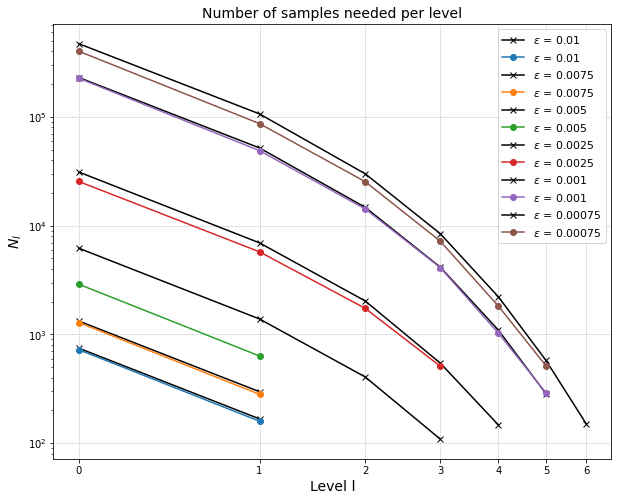

In [102]:
# plotting number of samples per level
plt.figure(5, figsize=(10,8))
# vector for number of levels
L_vec = np.array([i for i in range(1, 8)])
# plot for each epsilon in the list where more than one level is used
for i in range(4, 10):
    # number of samples for current epsilon
    N_ls = N_ls_vec[i]
    N_ls_ld = N_ls_vec_ld[i]
    # use log-log scale
    plt.loglog(L_vec[:len(N_ls)], N_ls, '-x', \
        label=rf'$\epsilon$ = {epsilons[i]}')
    plt.loglog(L_vec[:len(N_ls_ld)], N_ls_ld, '-o', \
        label=rf'$\epsilon$ = {epsilons[i]}')

plt.title(r'Number of samples needed per level', fontsize=14)
plt.xlabel('Level l', fontsize=14)
plt.ylabel(r'$N_l$', fontsize=14)
plt.grid(linestyle='--', linewidth=0.5)
plt.xticks([1,2,3,4,5,6,7], [0,1,2,3,4,5,6], fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=11)
plt.show()

In [130]:
x = 0.0001
y = '%.1e' % x

print (y)

1.0e-04


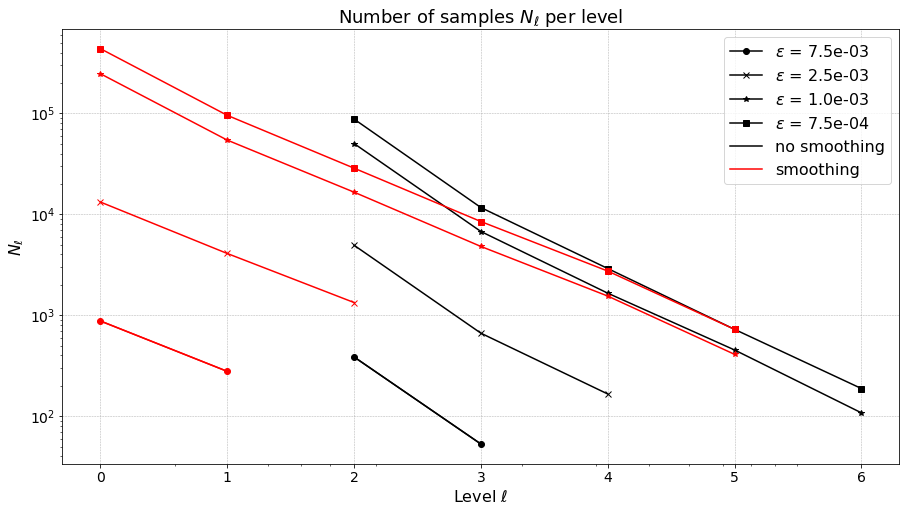

In [4]:
# plotting number of samples per level
plt.figure(5, figsize=(15,8))
# vector for number of levels
L_vec = np.array([i for i in range(1, 8)])
# plot for each epsilon in the list where more than one level is used

label = '%.1e' % epsilons[5]
plt.loglog(2**L_vec[2:2+len(N_ls_vec[5])], N_ls_vec[5], 'k-o', \
        label=rf'$\epsilon$ = {label}')
plt.loglog(2**L_vec[:len(N_ls_vec_ld[5])], N_ls_vec_ld[5], 'r-o')

label = '%.1e' % epsilons[7]
plt.loglog(2**L_vec[2:2+len(N_ls_vec[7])], N_ls_vec[7], 'k-x', \
        label=rf'$\epsilon$ = {label}')
plt.loglog(2**L_vec[:len(N_ls_vec_ld[7])], N_ls_vec_ld[7], 'r-x')

label = '%.1e' % epsilons[8]
plt.loglog(2**L_vec[2:2+len(N_ls_vec[8])], N_ls_vec[8], 'k-*', \
        label=rf'$\epsilon$ = {label}')
plt.loglog(2**L_vec[:len(N_ls_vec_ld[8])], N_ls_vec_ld[8], 'r-*')

label = '%.1e' % epsilons[9]
plt.loglog(2**L_vec[2:2+len(N_ls_vec[9])], N_ls_vec[9], 'k-s', \
        label=rf'$\epsilon$ = {label}')
plt.loglog(2**L_vec[:len(N_ls_vec_ld[9])], N_ls_vec_ld[9], 'r-s')


plt.loglog(2**L_vec[2:2+len(N_ls_vec[5])], N_ls_vec[5], 'k', label='no smoothing')
plt.loglog(2**L_vec[:len(N_ls_vec_ld[5])], N_ls_vec_ld[5], 'r', label='smoothing')

plt.title(rf'Number of samples $N_\ell$ per level', fontsize=18)
plt.xlabel(r'Level $\ell$', fontsize=16)
plt.ylabel(r'$N_\ell$', fontsize=16)
plt.grid(linestyle='--', linewidth=0.5)
plt.xticks(2**np.array([1,2,3,4,5,6,7]), [0,1,2,3,4,5,6], fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
# plt.gca().invert_xaxis()
plt.show()